In [142]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from wordcloud import WordCloud
from scipy.io import loadmat
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator

In [143]:
# Define directory paths and file names
image_folder = '102flowers'      # Folder containing the flower images
segmentation_folder = '102segmentations'  # Folder containing segmentation masks
label_file = 'imagelabels.mat'   # File containing image labels
setid_file = 'setid.mat'         # File containing data splits

In [144]:
# Load flower dictionary
flower_dict = {
    1: 'Pink primrose', 2: 'Globe thistle', 3: 'Blanket flower', 4: 'Trumpet creeper',
    5: 'Blackberry lily', 6: 'Snapdragon', 7: 'Colt\'s foot', 8: 'King protea',
    9: 'Spear thistle', 10: 'Yellow iris', 11: 'Globe-flower', 12: 'Purple coneflower',
    13: 'Peruvian lily', 14: 'Balloon flower', 15: 'Hard-leaved pocket orchid',
    16: 'Giant white arum lily', 17: 'Fire lily', 18: 'Pincushion flower', 19: 'Fritillary',
    20: 'Red ginger', 21: 'Grape hyacinth', 22: 'Corn poppy', 23: 'Prince of wales feathers',
    24: 'Stemless gentian', 25: 'Artichoke', 26: 'Canterbury bells', 27: 'Sweet william',
    28: 'Carnation', 29: 'Garden phlox', 30: 'Love in the mist', 31: 'Mexican aster',
    32: 'Alpine sea holly', 33: 'Ruby-lipped cattleya', 34: 'Cape flower', 35: 'Great masterwort',
    36: 'Siam tulip', 37: 'Sweet pea', 38: 'Lenten rose', 39: 'Barbeton daisy', 40: 'Daffodil',
    41: 'Sword lily', 42: 'Poinsettia', 43: 'Bolero deep blue', 44: 'Wallflower', 45: 'Marigold',
    46: 'Buttercup', 47: 'Oxeye daisy', 48: 'English marigold', 49: 'Common dandelion',
    50: 'Petunia', 51: 'Wild pansy', 52: 'Primula', 53: 'Sunflower', 54: 'Pelargonium',
    55: 'Bishop of llandaff', 56: 'Gaura', 57: 'Geranium', 58: 'Orange dahlia', 59: 'Tiger lily',
    60: 'Pink-yellow dahlia', 61: 'Cautleya spicata', 62: 'Japanese anemone', 63: 'Black-eyed susan',
    64: 'Silverbush', 65: 'Californian poppy', 66: 'Osteospermum', 67: 'Spring crocus',
    68: 'Bearded iris', 69: 'Windflower', 70: 'Moon orchid', 71: 'Tree poppy', 72: 'Gazania',
    73: 'Azalea', 74: 'Water lily', 75: 'Rose', 76: 'Thorn apple', 77: 'Morning glory',
    78: 'Passion flower', 79: 'Lotus', 80: 'Toad lily', 81: 'Bird of paradise', 82: 'Anthurium',
    83: 'Frangipani', 84: 'Clematis', 85: 'Hibiscus', 86: 'Columbine', 87: 'Desert-rose',
    88: 'Tree mallow', 89: 'Magnolia', 90: 'Cyclamen', 91: 'Watercress', 92: 'Monkshood',
    93: 'Canna lily', 94: 'Hippeastrum', 95: 'Bee balm', 96: 'Ball moss', 97: 'Foxglove',
    98: 'Bougainvillea', 99: 'Camellia', 100: 'Mallow', 101: 'Mexican petunia', 102: 'Bromelia'
}


In [145]:
# Load image labels from imagelabels.mat
label_data = loadmat(label_file)
labels = label_data['labels'][0]

# Load data splits from setid.mat
setid_data = loadmat(setid_file)
train_ids = setid_data['trnid'][0] - 1  # Adjust indices to start from 0
val_ids = setid_data['valid'][0] - 1   # Adjust indices to start from 0
test_ids = setid_data['tstid'][0] - 1  # Adjust indices to start from 0

In [154]:
# Data augmentation setup with custom preprocessing functions
def adjust_dynamic_range(image):
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image

def preprocess_function(image):
    # Standard normalization with ImageNet mean and std
    mean = np.array([123.68, 116.779, 103.939])
    std = np.array([58.393, 57.12, 57.375])
    return (image - mean) / std

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

In [147]:
# Function to preprocess images
def preprocess_image(image_path, target_size):
    image = Image.open(image_path)
    image = image.resize(target_size)
    image_array = img_to_array(image)
    # Subtract ImageNet mean pixel values
    mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
    image_array -= mean
    return image_array


def load_and_preprocess_images(image_folder, image_ids, labels, target_size):
    images = []
    image_labels = []
    for image_id in image_ids:
        image_path = os.path.join(image_folder, f'image_{image_id + 1:05d}.jpg')
        if os.path.exists(image_path):
            image_array = preprocess_image(image_path, target_size)
            images.append(image_array)
            image_labels.append(labels[image_id])
        else:
            print(f"Image file not found: {image_path}")
    return np.array(images), np.array(image_labels)

In [148]:
# Preprocess training images
target_size = (224, 224)
train_images, train_labels = load_and_preprocess_images(image_folder, train_ids, labels, target_size)

# Preprocess validation images
val_images, val_labels = load_and_preprocess_images(image_folder, val_ids, labels, target_size)

# Preprocess testing images
test_images, test_labels = load_and_preprocess_images(image_folder, test_ids, labels, target_size)

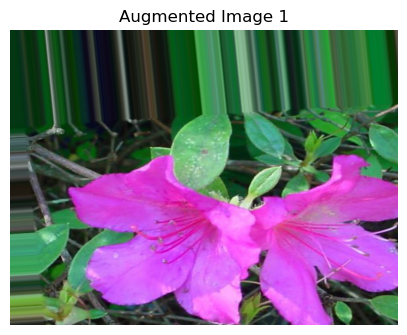

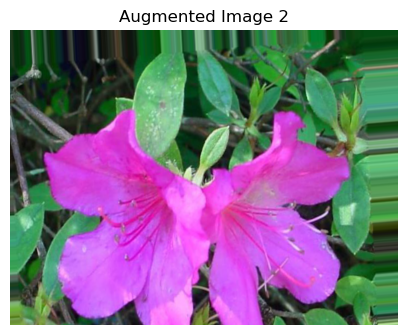

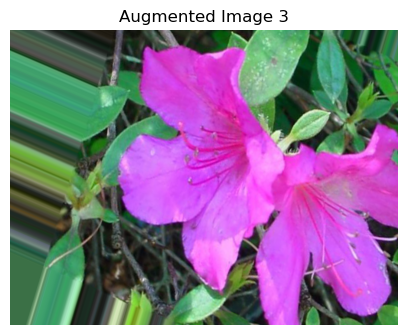

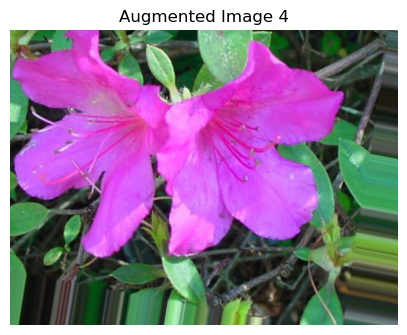

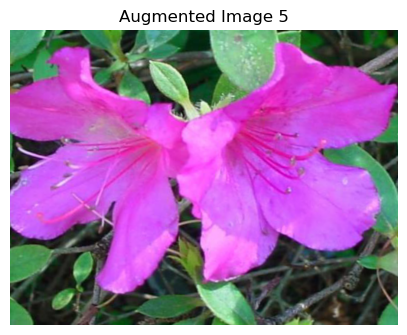

In [155]:
# Select a random image for augmentation
random_image_path = np.random.choice(os.listdir(image_folder))
sample_image = Image.open(os.path.join(image_folder, random_image_path))
sample_image_array = img_to_array(sample_image)

# Reshape the image array for augmentation
sample_image_array = np.expand_dims(sample_image_array, axis=0)

# Generate augmented images
num_augmented_images = 5
for i, augmented_image_array in enumerate(datagen.flow(sample_image_array, batch_size=1)):
    augmented_image = Image.fromarray(np.uint8(augmented_image_array[0]))
    plt.figure(figsize=(5, 5))
    plt.imshow(augmented_image)
    plt.axis('off')
    plt.title(f'Augmented Image {i+1}')
    plt.show()
    if i + 1 == num_augmented_images:
        break

In [150]:
# Load and examine image labels
label_data = loadmat('imagelabels.mat')
labels = label_data['labels'][0]

print("Labels:", labels)
num_unique_labels = len(set(labels))
print("Number of unique labels:", num_unique_labels)

Labels: [77 77 77 ... 62 62 62]
Number of unique labels: 102


In [151]:
def load_and_preprocess_segmentation_masks(segmentation_folder, image_ids, target_size):
    segmentations = []
    for image_id in image_ids:
        segmentation_path = os.path.join(segmentation_folder, f'segmim_{image_id + 1:05d}.jpg')
        if os.path.exists(segmentation_path):
            segmentation = Image.open(segmentation_path)
            segmentation = segmentation.resize(target_size)
            segmentation_array = img_to_array(segmentation)
            segmentation_array /= 255.0
            segmentations.append(segmentation_array)
        else:
            print(f"Segmentation mask file not found: {segmentation_path}")
            segmentations.append(np.zeros((target_size[0], target_size[1], 1), dtype=np.float32))
    return np.array(segmentations)


# Preprocess segmentation masks for training, validation, and testing
train_segmentations = load_and_preprocess_segmentation_masks(segmentation_folder, train_ids, target_size)
val_segmentations = load_and_preprocess_segmentation_masks(segmentation_folder, val_ids, target_size)
test_segmentations = load_and_preprocess_segmentation_masks(segmentation_folder, test_ids, target_size)

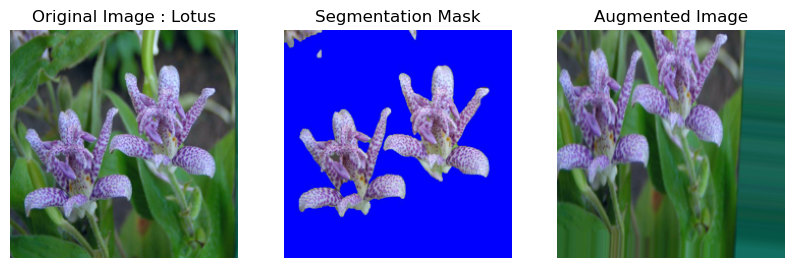

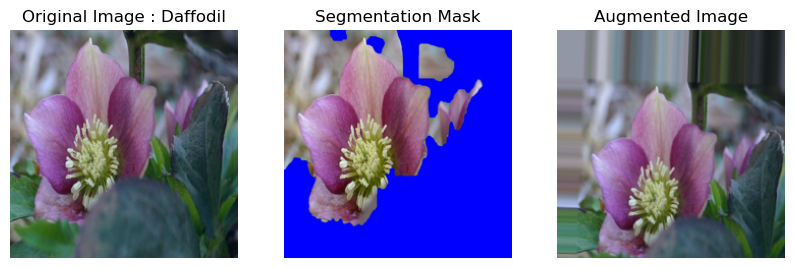

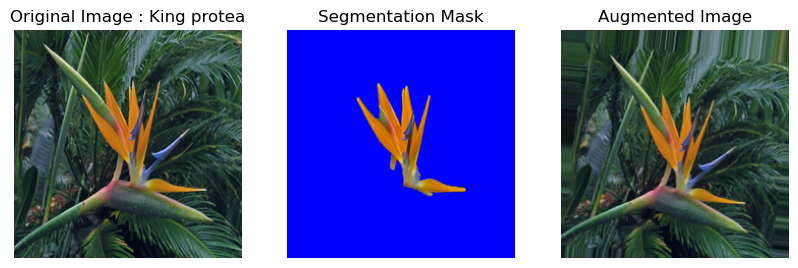

In [152]:
# Modify the function to use flower_dict for getting class labels
def visualize_random_augmented_segmentation_examples(images, segmentations, labels, flower_dict, image_generator, num_examples=3):
    random_indices = np.random.choice(len(images), num_examples, replace=False)
    for idx in random_indices:
        # Normalize or clip the image data to [0, 1] for floats
        image = images[idx].astype(np.float32)  # Ensure image is float32 for processing
        image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]

        # Prepare the segmentation mask, ensuring it's suitable for display
        segmentation_mask = segmentations[idx]
        if segmentation_mask.shape[-1] == 1:
            segmentation_mask = segmentation_mask[:, :, 0]  # If it's single-channel, squeeze it.
        segmentation_mask = (segmentation_mask - segmentation_mask.min()) / (segmentation_mask.max() - segmentation_mask.min())  # Normalize

        # Create figure for original image and segmentation
        plt.figure(figsize=(10, 5))

        # Display the original image
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title(f'Original Image : {flower_dict[labels[idx]]}')
        plt.axis('off')

        # Display the segmentation mask
        plt.subplot(1, 3, 2)
        plt.imshow(segmentation_mask, cmap='gray')
        plt.title('Segmentation Mask')
        plt.axis('off')

        # Generate augmented image
        augmented_image = image_generator.random_transform(image)
        augmented_segmentation = image_generator.random_transform(segmentation_mask)

        # Display the augmented image
        plt.subplot(1, 3, 3)
        plt.imshow(augmented_image)
        plt.title('Augmented Image')
        plt.axis('off')

        plt.show()

# Example usage:
visualize_random_augmented_segmentation_examples(train_images, train_segmentations, train_labels, flower_dict, datagen)


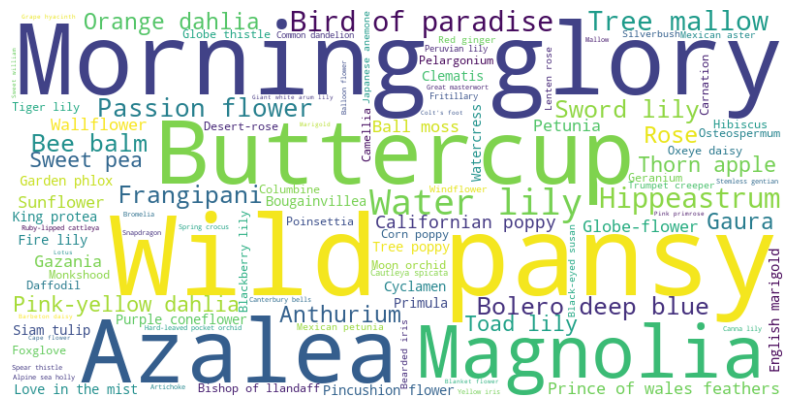

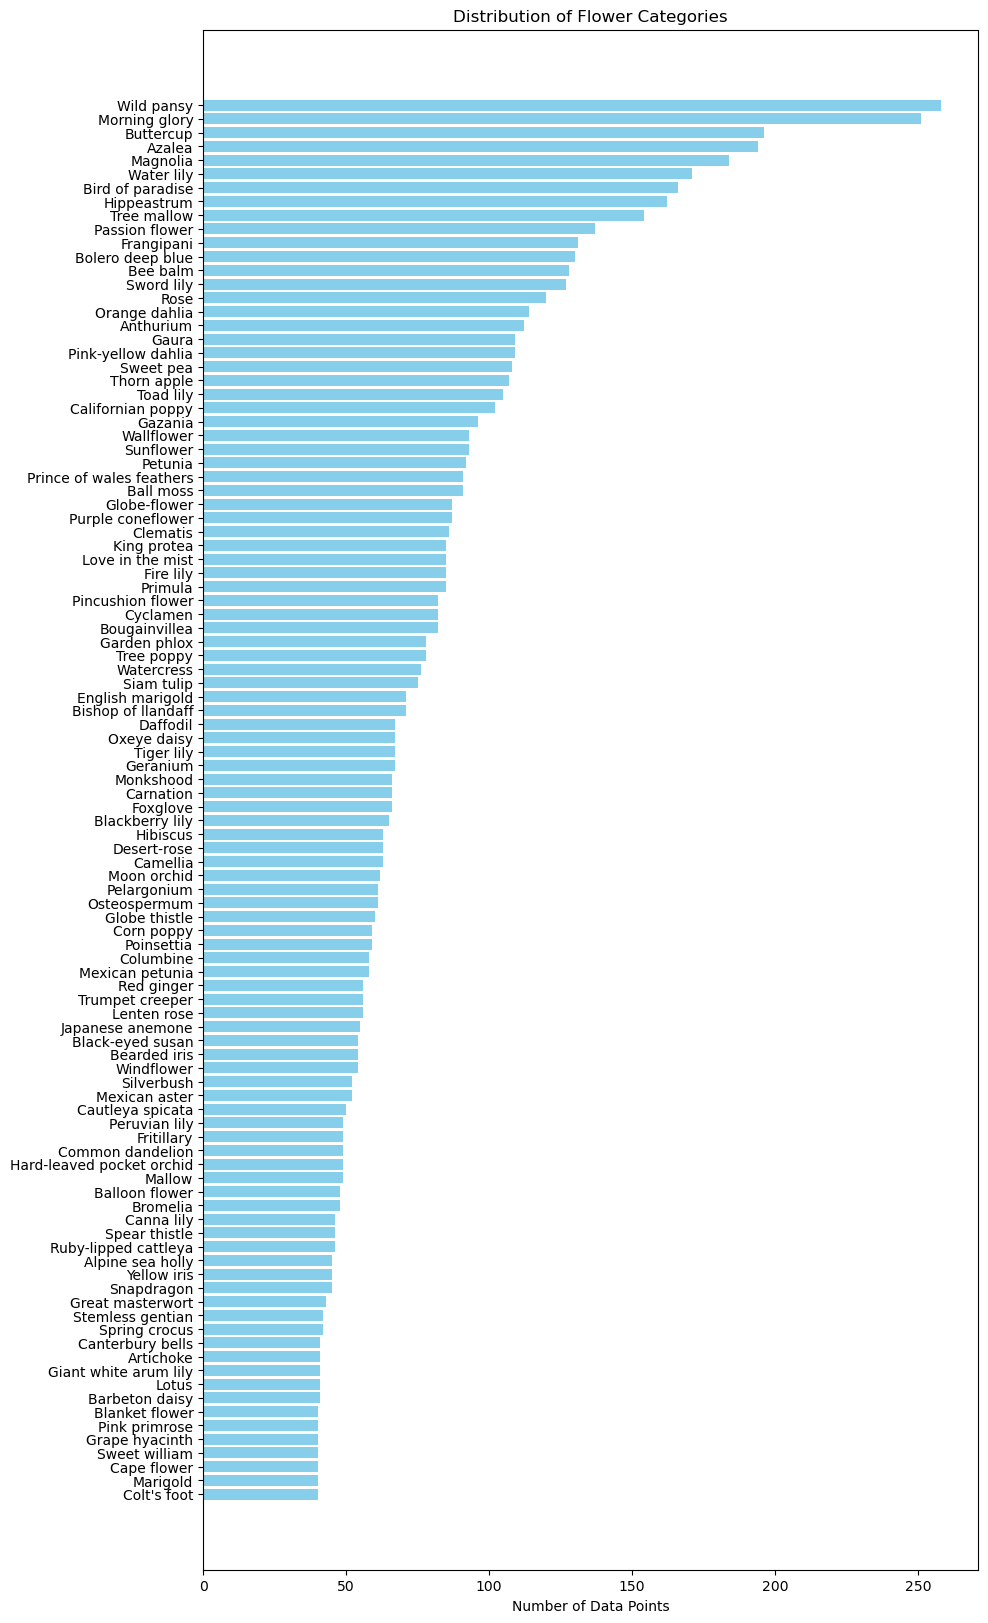

In [153]:
# Calculate the frequency of each flower category
flower_counts = {}
for label in labels:
    if label in flower_dict:
        flower_name = flower_dict[label]
        if flower_name in flower_counts:
            flower_counts[flower_name] += 1
        else:
            flower_counts[flower_name] = 1
    else:
        print(f"Label {label} not found in the flower dictionary.")

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(flower_counts)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Sort flower names and counts by counts in descending order
sorted_flower_names = sorted(flower_counts.keys(), key=lambda x: flower_counts[x], reverse=True)
sorted_flower_counts = [flower_counts[name] for name in sorted_flower_names]

# Plotting the horizontal bar chart
plt.figure(figsize=(10, 20))
plt.barh(sorted_flower_names, sorted_flower_counts, color='skyblue')
plt.xlabel('Number of Data Points')
plt.title('Distribution of Flower Categories')
plt.gca().invert_yaxis()  # Invert y-axis to have the flower with the highest count at the top
plt.show()
